In [1]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [2]:
LOWER = 1
UPPER = 11

# SST-2

In [3]:
train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
eval_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

In [4]:
train_df.set_axis(['text', 'label'], axis=1, inplace=True)
eval_df.set_axis(['text', 'label'], axis=1, inplace=True)

In [5]:
train_df

text  label
0     a stirring , funny and finally transporting re...      1
1     apparently reassembled from the cutting room f...      0
2     they presume their audience wo n't sit still f...      0
3     this is a visually stunning rumination on love...      1
4     jonathan parker 's bartleby should have been t...      1
...                                                 ...    ...
6915  painful , horrifying and oppressively tragic ,...      1
6916  take care is nicely performed by a quintet of ...      0
6917  the script covers huge , heavy topics in a bla...      0
6918  a seriously bad film with seriously warped log...      0
6919  a deliciously nonsensical comedy about a city ...      1

[6920 rows x 2 columns]

In [6]:
eval_df

text  label
0          no movement , no yuks , not much of anything      0
1     a gob of drivel so sickly sweet , even the eag...      0
2     gangs of new york is an unapologetic mess , wh...      0
3     we never really feel involved with the story ,...      0
4                 this is one of polanski 's best films      1
...                                                 ...    ...
1816  an often deadly boring , strange reading of a ...      0
1817  the problem with concept films is that if the ...      0
1818  safe conduct , however ambitious and well inte...      0
1819  a film made with as little wit , interest , an...      0
1820  but here 's the real damn it is n't funny , ei...      0

[1821 rows x 2 columns]

In [7]:
def sentence_pairs_generation(sentences, labels, pairs, neg_lab=0.0):
    # initialize two empty lists to hold the (sentence, sentence) pairs and
    # labels to indicate if a pair is positive or negative

    numClassesList = np.unique(labels)
    idx = [np.where(labels == i)[0] for i in numClassesList]

    for idxA in range(len(sentences)):      
        currentSentence = sentences[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
        posSentence = sentences[idxB]
              # prepare a positive pair and update the sentences and labels
              # lists, respectively
        pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

        negIdx = np.where(labels != label)[0]
        negSentence = sentences[np.random.choice(negIdx)]
              # prepare a negative pair of images and update our lists
        pairs.append(InputExample(texts=[currentSentence, negSentence], label=neg_lab))

    # return a 2-tuple of our image pairs and labels
    return (pairs)

In [8]:
def SetFit(train_df, eval_df, epoch, neg_lab):
    st_model = 'paraphrase-mpnet-base-v2' 
    num_training = 32 
    num_itr = 5 
    text_col=train_df.columns.values[0] 
    category_col=train_df.columns.values[1]
    x_eval = eval_df[text_col].values.tolist()
    y_eval = eval_df[category_col].values.tolist()
    
    set_seed(0)
    examples = []
    # Equal samples per class training
    for label in train_df['label'].unique():
        subset = train_df[train_df['label']==label]
        if len(subset) > num_training:
            examples.append(subset.sample(num_training))
        else:
            examples.append(subset)
    train_df_sample = pd.concat(examples)
    x_train = train_df_sample[text_col].values.tolist()
    y_train = train_df_sample[category_col].values.tolist()
    
    train_examples = [] 
    for x in range(num_itr):
        train_examples = sentence_pairs_generation(np.array(x_train), 
                                                   np.array(y_train), 
                                                   train_examples, 
                                                   neg_lab)


    orig_model = SentenceTransformer(st_model)
    model = SentenceTransformer(st_model)

    # S-BERT adaptation 
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
    train_loss = losses.CosineSimilarityLoss(model)
    #epochs originally was 1
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=epoch, warmup_steps=10, show_progress_bar=True)
    
    # No Fit
    X_train_noFT = orig_model.encode(x_train)
    X_eval_noFT = orig_model.encode(x_eval)

    sgd =  LogisticRegression()
    sgd.fit(X_train_noFT, y_train)
    y_pred_eval_sgd = sgd.predict(X_eval_noFT)
    print('train epochs: {}'.format(epoch))

    print('Acc. No Fit', accuracy_score(y_eval, y_pred_eval_sgd))

    # With Fit (SetFit)
    X_train = model.encode(x_train)
    X_eval = model.encode(x_eval)

    sgd =  LogisticRegression()
    sgd.fit(X_train, y_train)
    y_pred_eval_sgd = sgd.predict(X_eval)
    
    acc = accuracy_score(y_eval, y_pred_eval_sgd)

    print('Acc. SetFit {}'.format(acc))
    
    plot_fit(X_train_noFT, X_eval_noFT, y_eval, y_train, X_train, X_eval, epoch)
    
    return acc
    

In [9]:
def plot_fit(X_train_noFT, X_eval_noFT, y_eval, y_train, X_train, X_eval, epoch):
    plt.figure(figsize=(20,10))

    #Plot X_train_noFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train_noFT))
    plt.subplot(221)
    plt.title('X_train No Fit')

    for i, t in enumerate(set(np.array(y_train))):
        idx = np.array(y_train) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

    #Plot X_eval noFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval_noFT))
    plt.subplot(223)
    plt.title('X_eval No Fit')

    for i, t in enumerate(set(np.array(y_eval))):
        idx = np.array(y_eval) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   
    plt.legend(bbox_to_anchor=(1, 1));


    #Plot X_train SetFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

    plt.subplot(222)
    plt.title('X_train SetFit: epochs = {}'.format(epoch))

    for i, t in enumerate(set(np.array(y_train))):
        idx = np.array(y_train) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

    #Plot X_eval SetFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval))
    plt.subplot(224)
    plt.title('X_eval SetFit: epochs = {}'.format(epoch))

    for i, t in enumerate(set(np.array(y_eval))):
        idx = np.array(y_eval) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

# SST-2 negative label == 0

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 1
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8890719384953323


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 2
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.9077429983525536


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 3
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.9055464030752334


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 4
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.9049972542559034


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 5
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.9082921471718836


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 6
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.9060955518945635


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 7
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.9033498077979132


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 8
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.9066447007138935


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 9
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.9099395936298736


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 10
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.9060955518945635


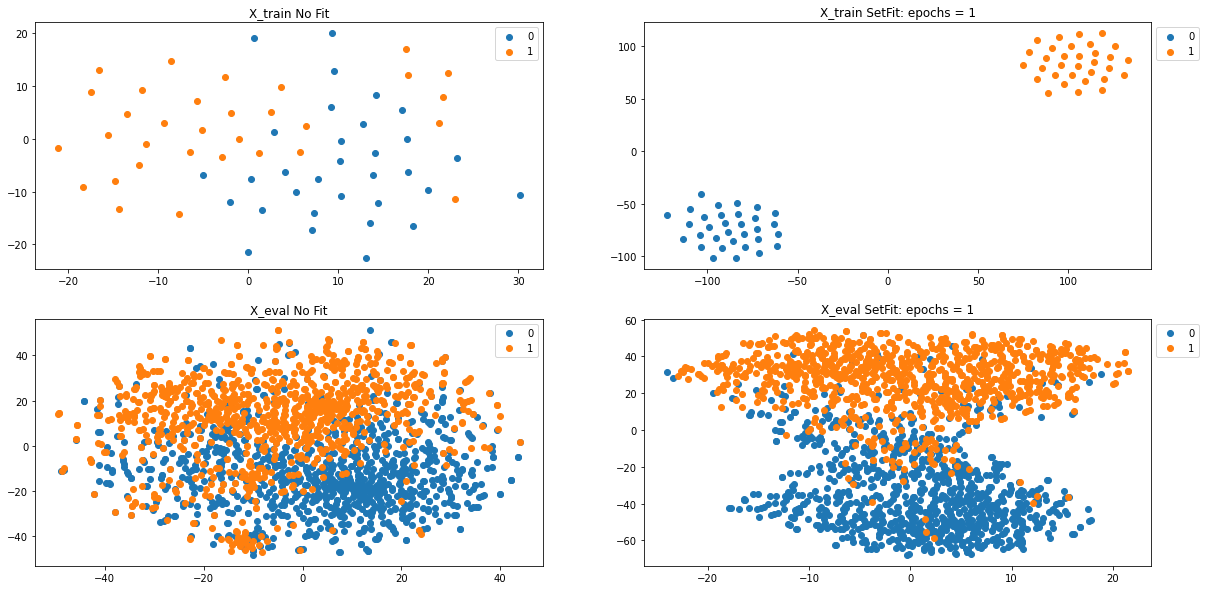

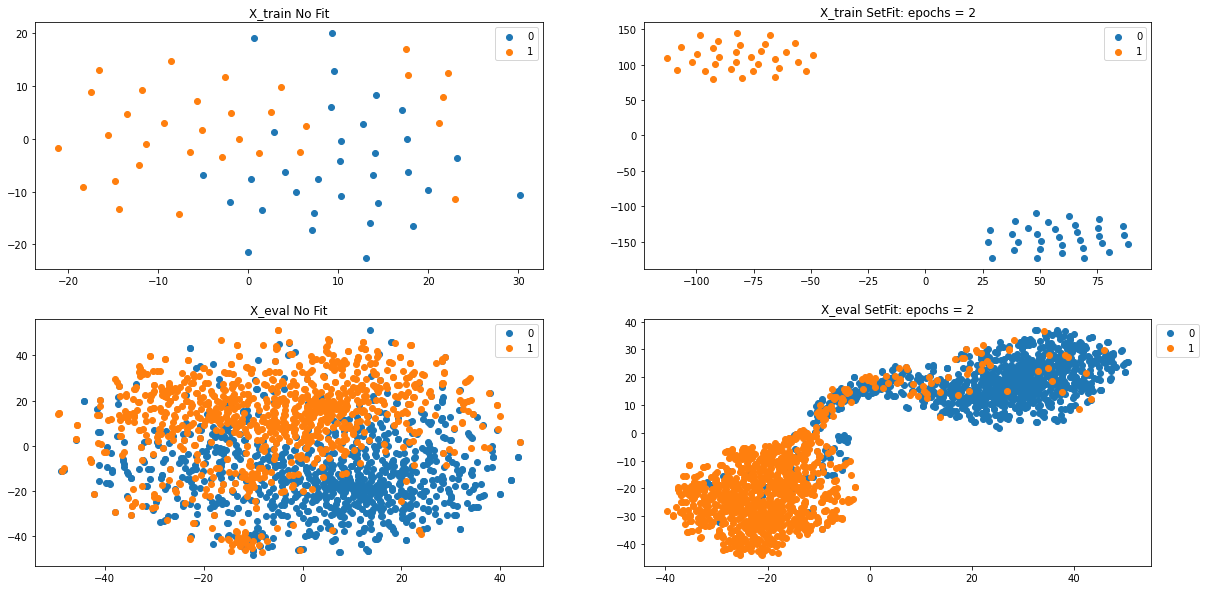

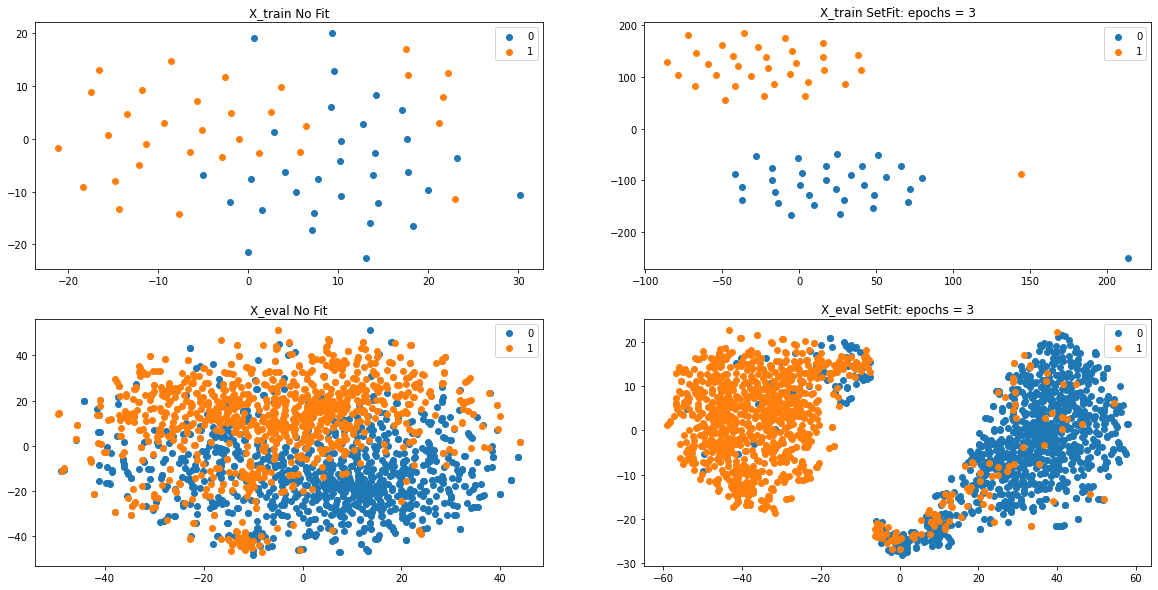

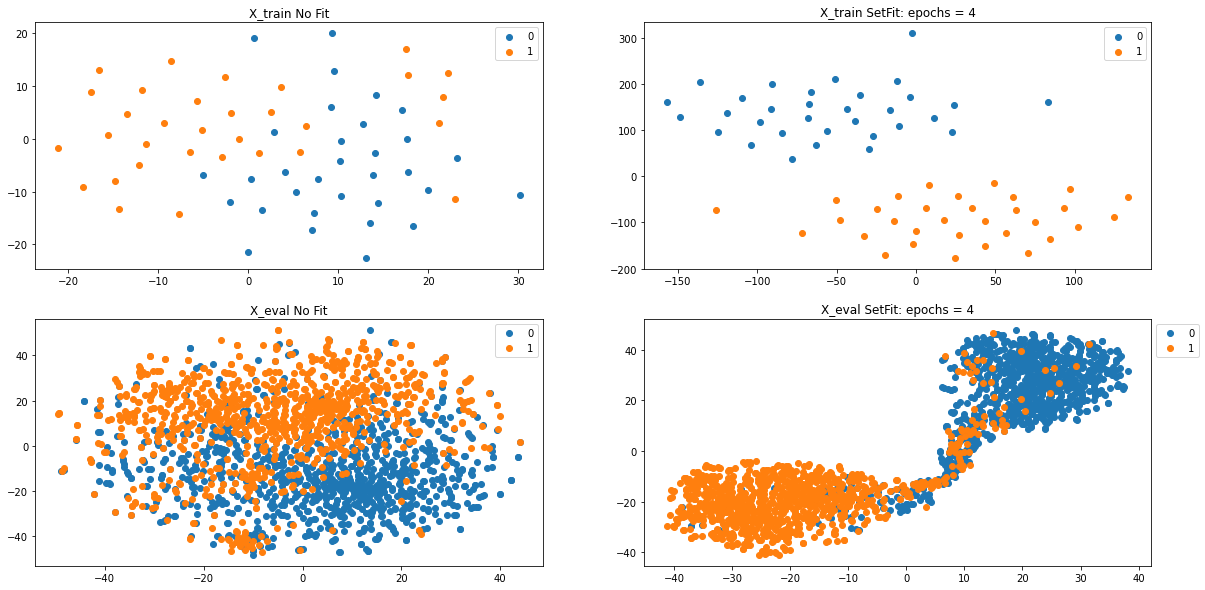

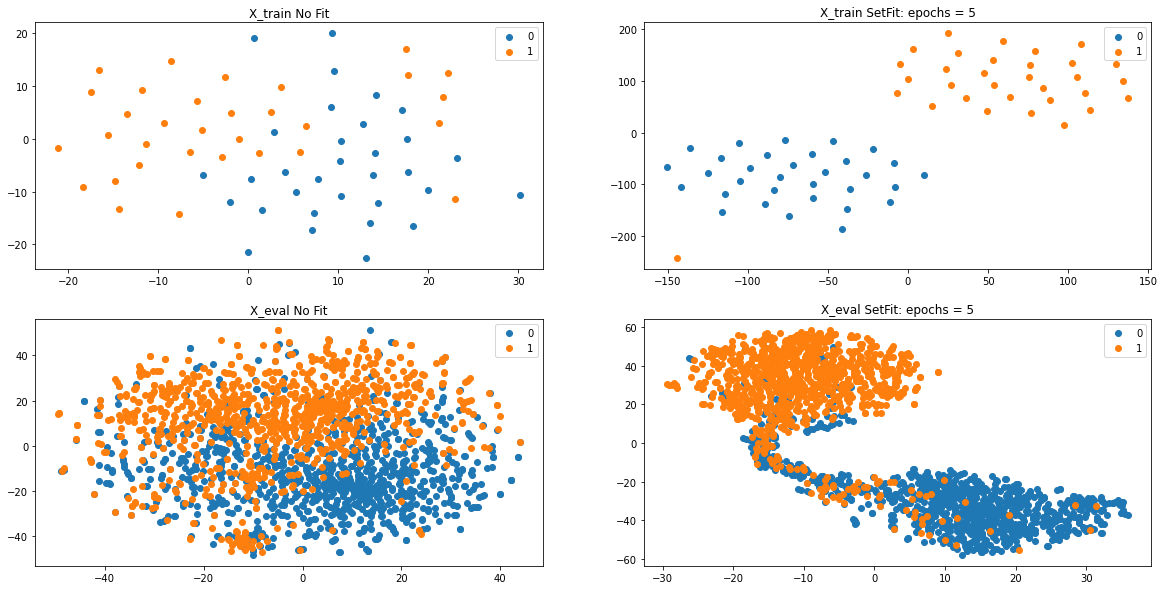

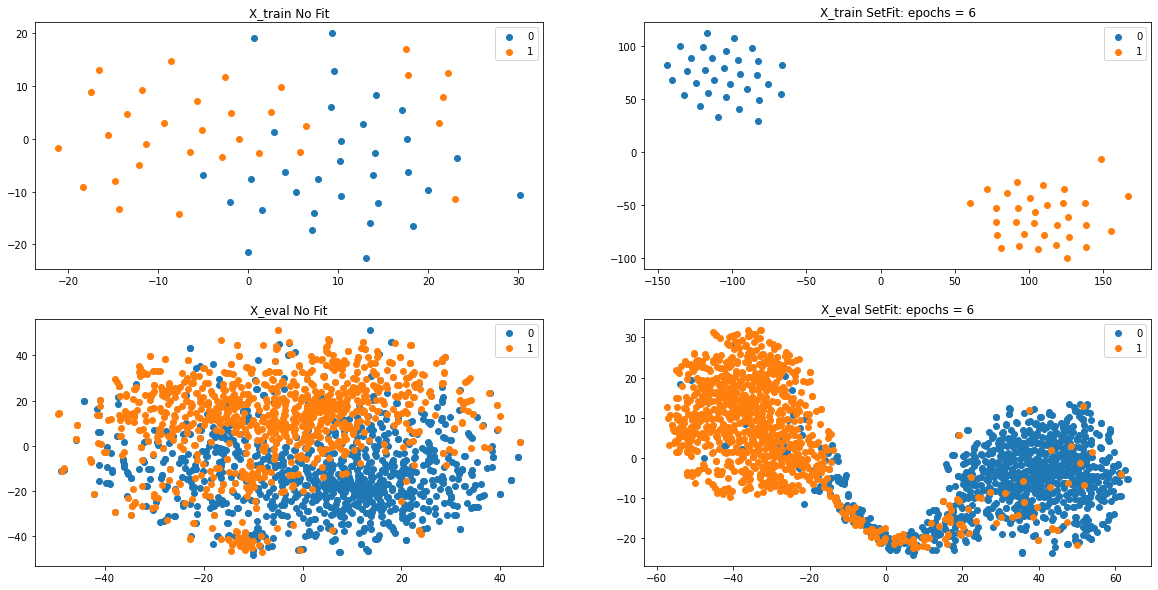

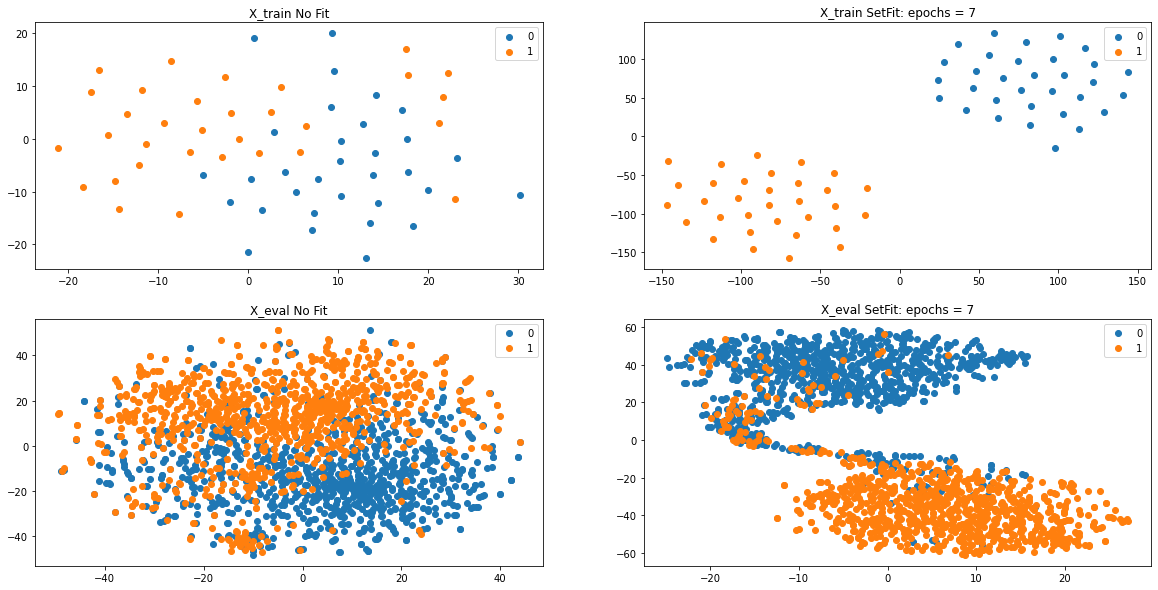

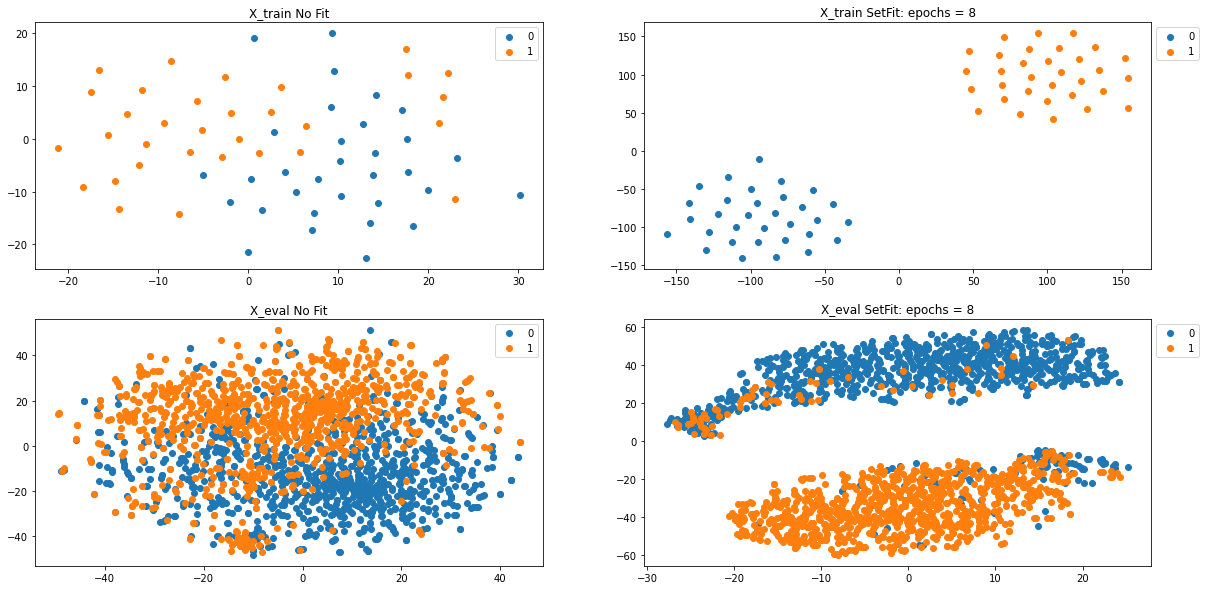

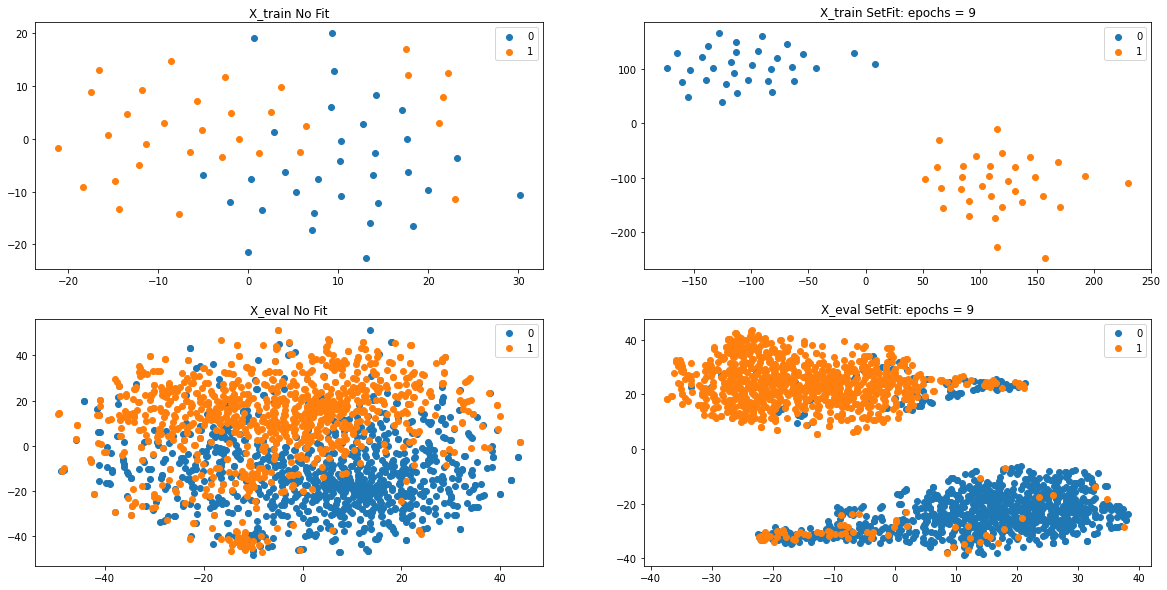

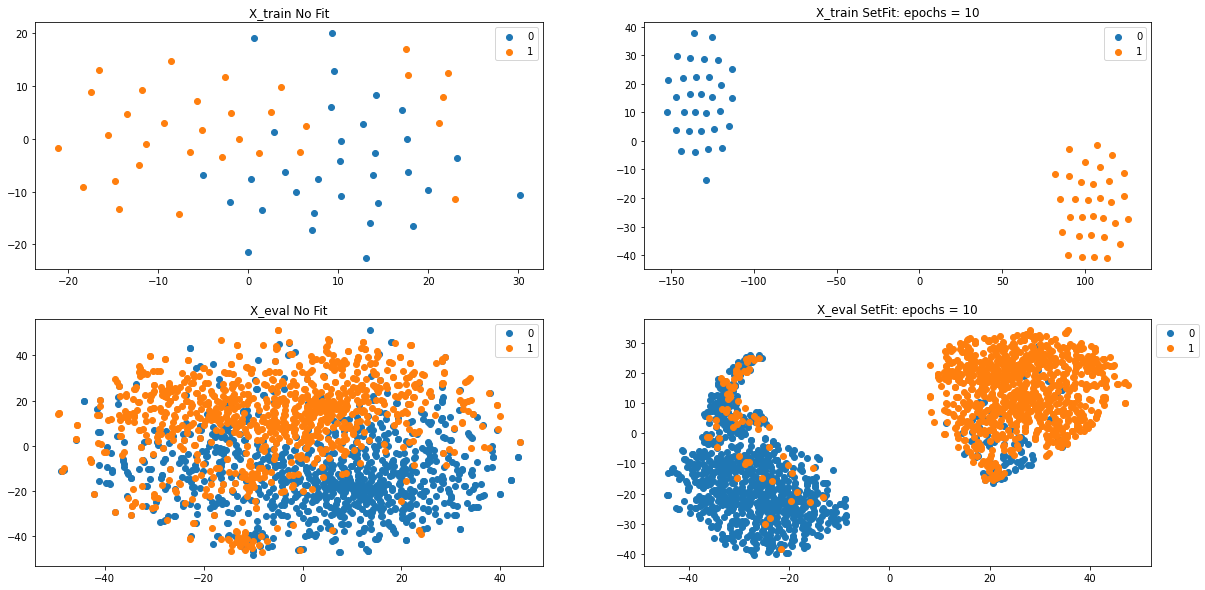

In [10]:
sst2_0_accs = []
for epoch in range(LOWER, UPPER):
    acc = SetFit(train_df, eval_df, epoch, neg_lab=0.0)
    sst2_0_accs.append(acc)

# SST-2 negative label == -1

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 1
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8830313014827018


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 2
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8890719384953323


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 3
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8775398132894014


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 4
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8780889621087314


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 5
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8791872597473915


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 6
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8775398132894014


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 7
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8808347062053816


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 8
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8791872597473915


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 9
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8802855573860516


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

train epochs: 10
Acc. No Fit 0.8742449203734212
Acc. SetFit 0.8819330038440417


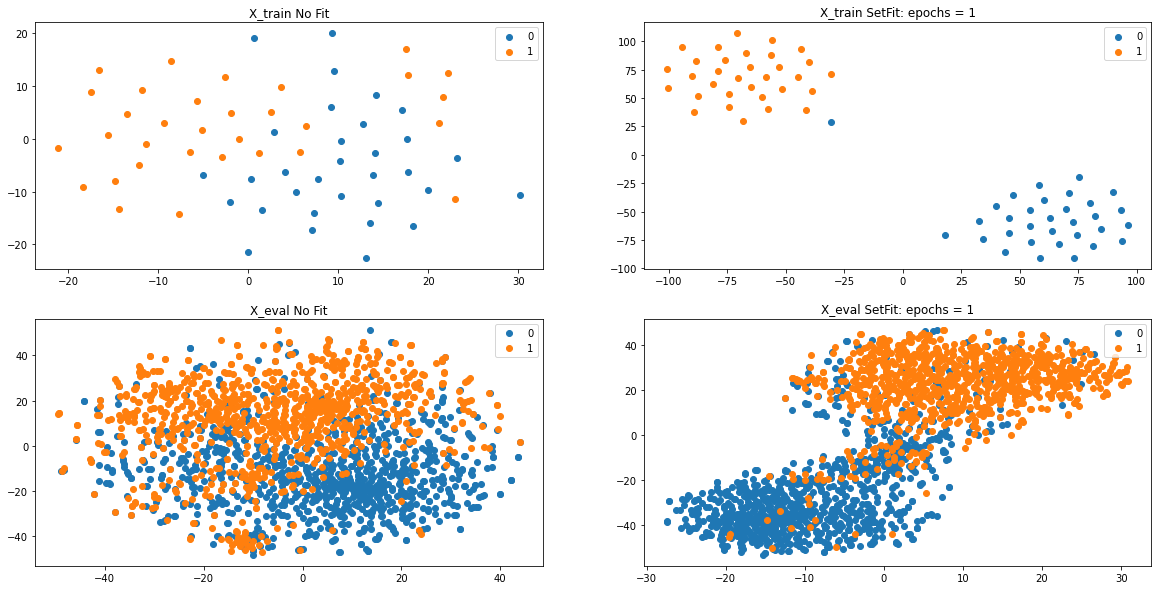

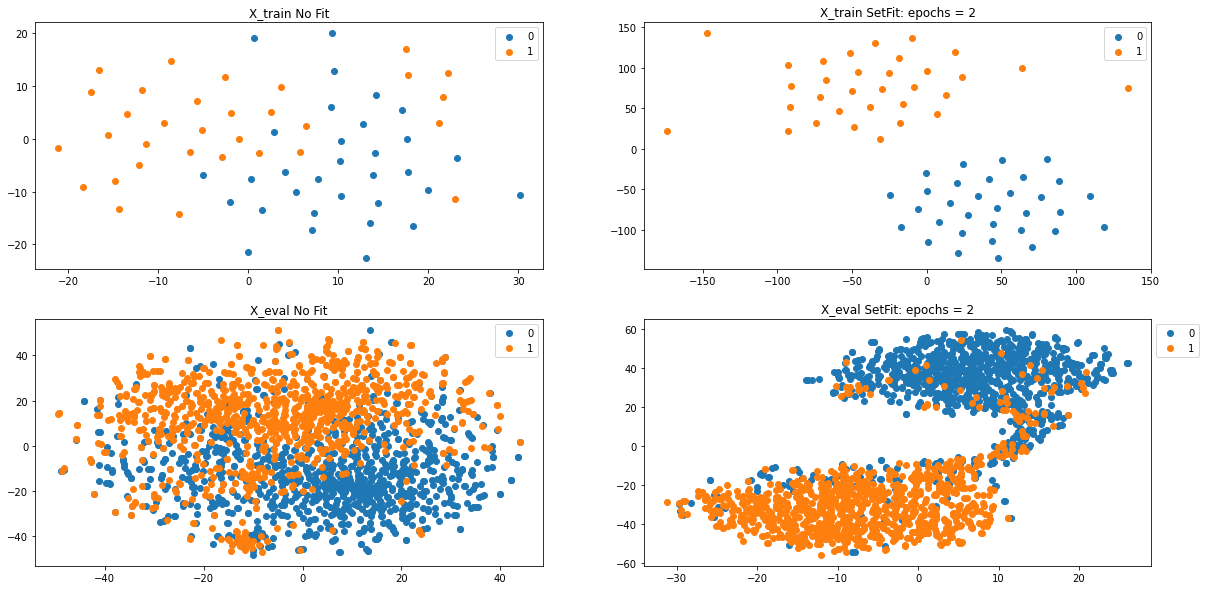

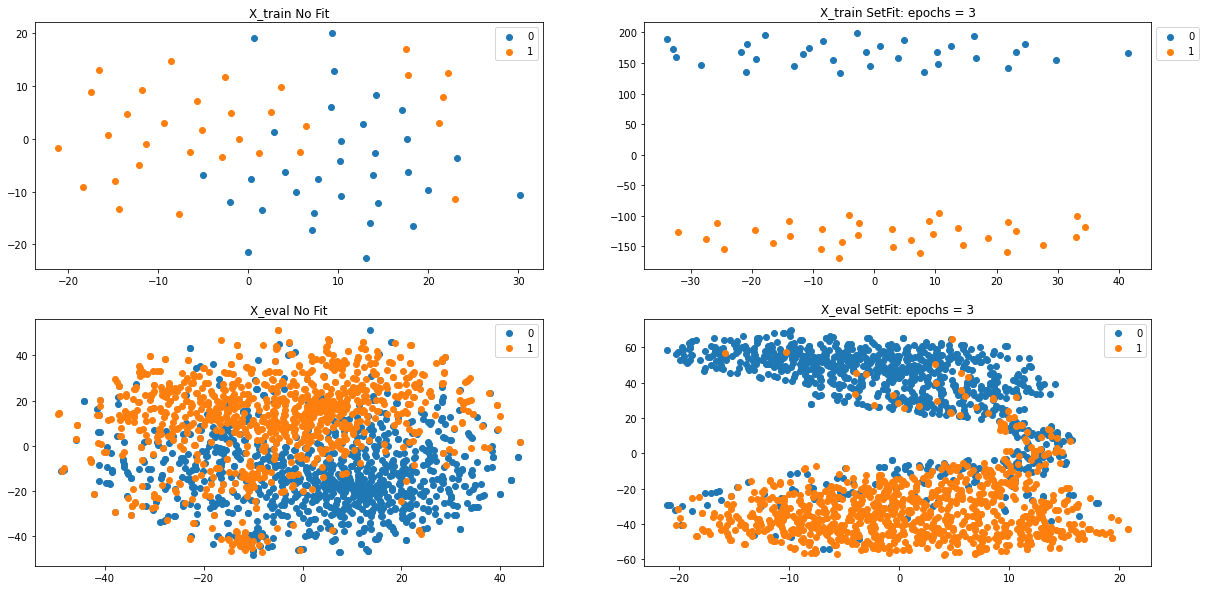

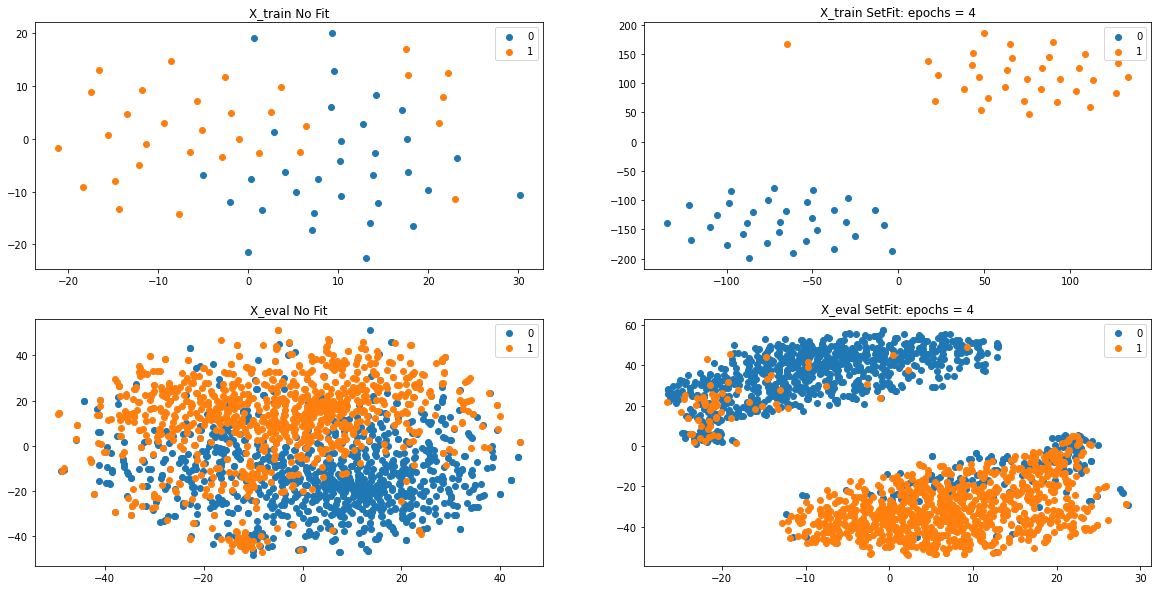

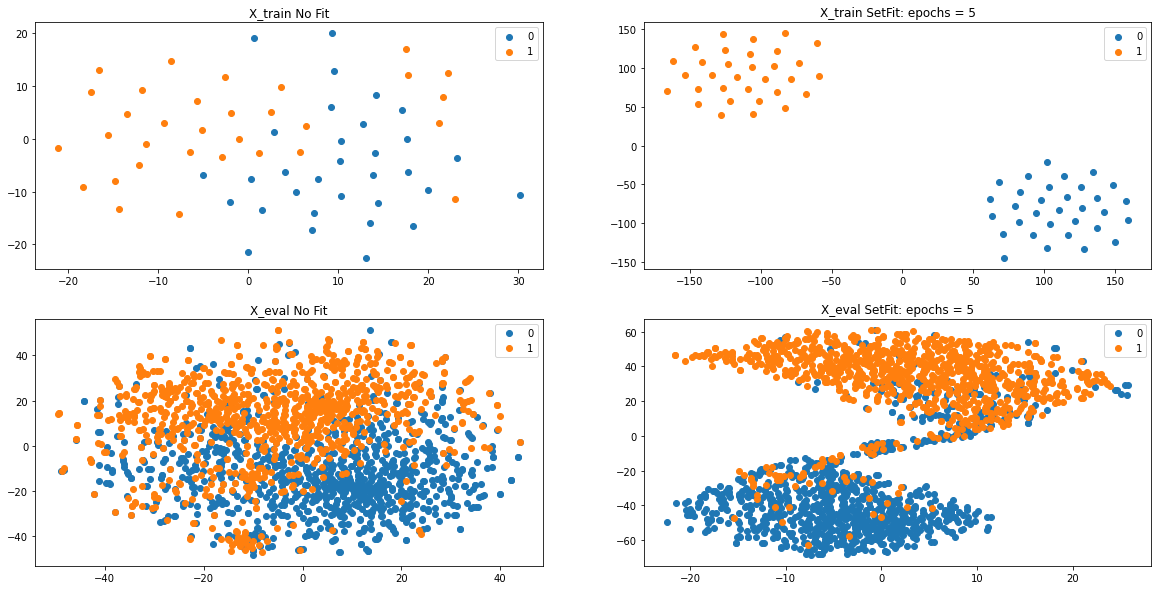

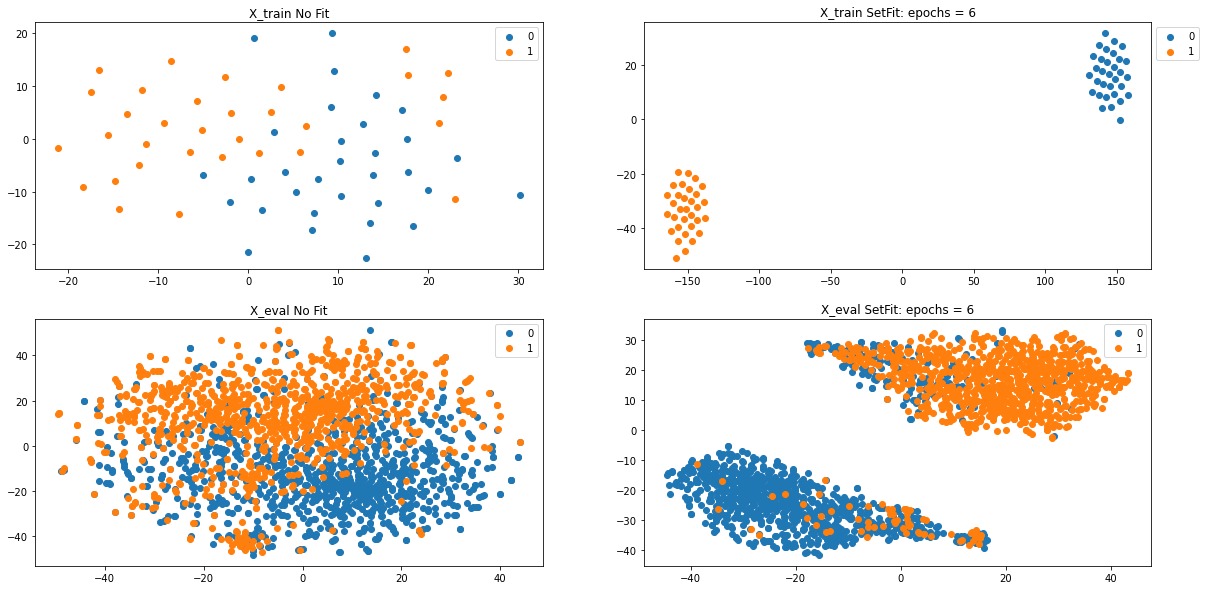

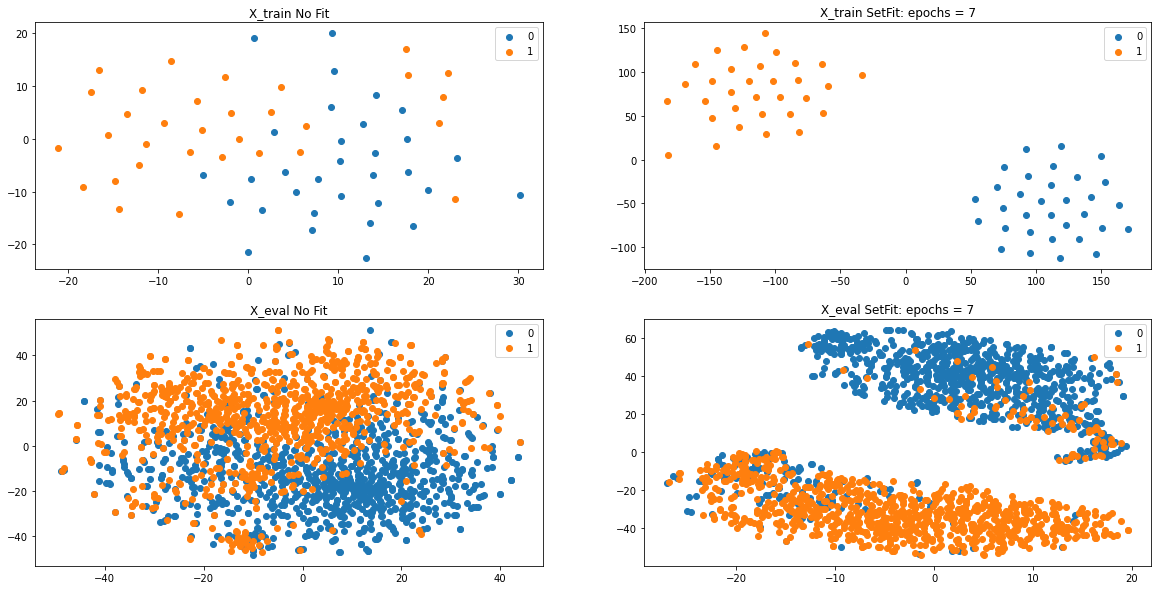

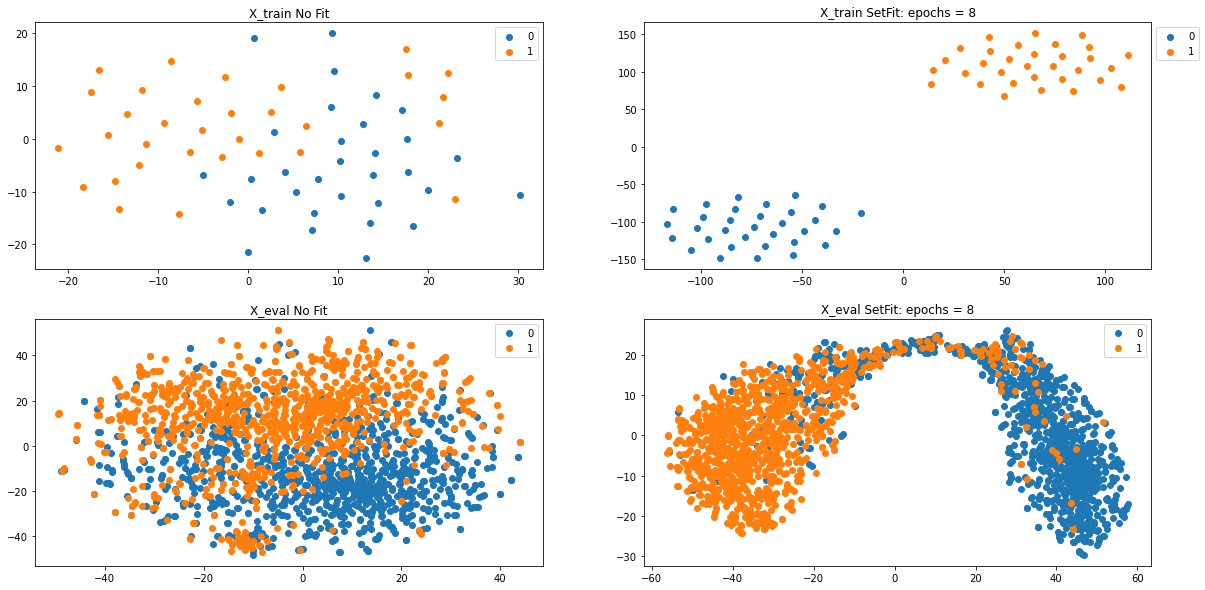

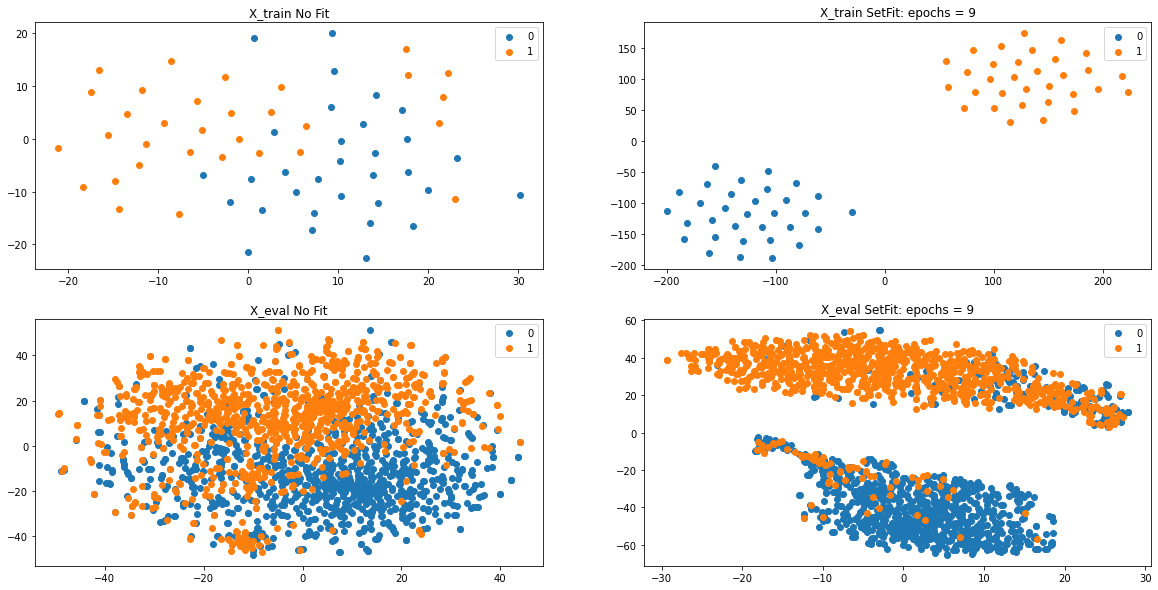

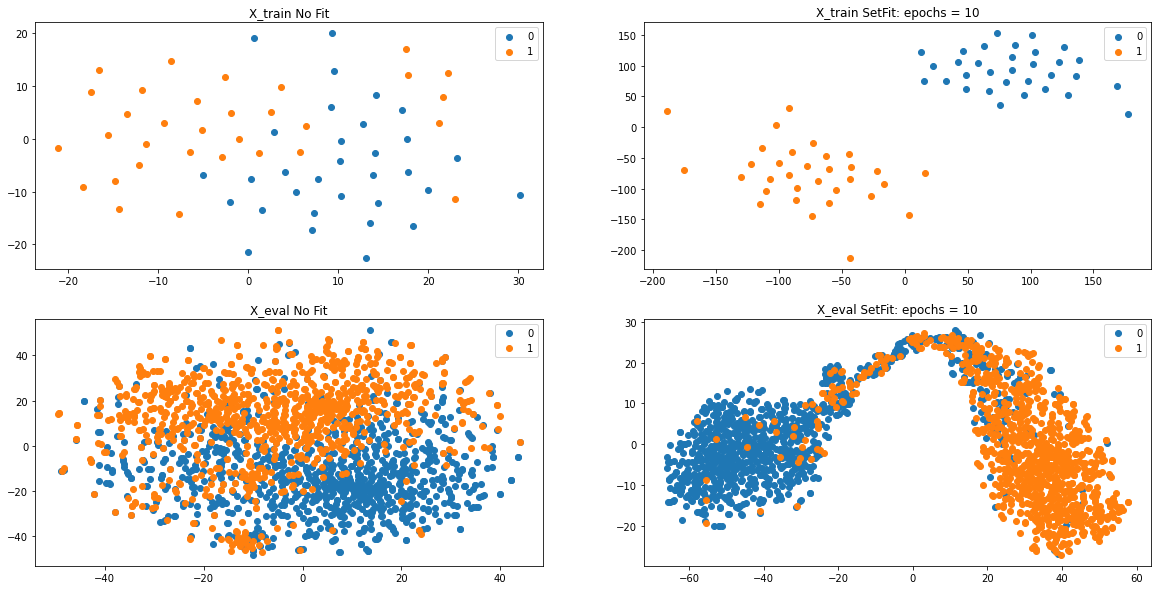

In [11]:
sst2_neg1_accs = []
for epoch in range(LOWER, UPPER):
    acc = SetFit(train_df, eval_df, epoch, neg_lab=-1.0)
    sst2_neg1_accs.append(acc)

# SST-5

In [12]:
def fix_df(df):
    labels, txt = [], []
    for text in df['text'].to_list():
        label = text[0]
        keep_text = text[1:]
        labels.append(int(label))
        txt.append(keep_text)
    return pd.DataFrame({'text': txt, 'label': labels})

In [13]:
#sst5 from here: https://github.com/toriving/text-classification-transformers/tree/master/data_in/sst5
names = ['text']
sst5_train = pd.read_csv('stsa_fine_train.txt',names=names, delimiter='\t', header=None)
sst5_dev = pd.read_csv('stsa_fine_dev.txt',names=names, delimiter='\t', header=None)

In [14]:
train_df = fix_df(sst5_train)
eval_df = fix_df(sst5_dev)

In [15]:
train_df

text  label
0      a stirring , funny and finally transporting r...      4
1      apparently reassembled from the cutting-room ...      1
2      they presume their audience wo n't sit still ...      1
3      the entire movie is filled with deja vu momen...      2
4      this is a visually stunning rumination on lov...      3
...                                                 ...    ...
8539   take care is nicely performed by a quintet of...      1
8540   the script covers huge , heavy topics in a bl...      1
8541   a seriously bad film with seriously warped lo...      1
8542   it 's not too racy and it 's not too offensive .      2
8543   a deliciously nonsensical comedy about a city...      4

[8544 rows x 2 columns]

In [16]:
eval_df

text  label
0      in his first stab at the form , jacquot takes...      2
1                          one long string of cliches .      1
2      if you 've ever entertained the notion of doi...      1
3      k-19 exploits our substantial collective fear...      0
4      it 's played in the most straight-faced fashi...      1
...                                                 ...    ...
1096   `` the ring '' is pretty much an english-lang...      2
1097       smart , provocative and blisteringly funny .      3
1098   this one is definitely one to skip , even for...      0
1099   charles ' entertaining film chronicles seinfe...      3
1100   an effectively creepy , fear-inducing -lrb- n...      4

[1101 rows x 2 columns]

# SST-5 negative label == 0

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 1
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4940962761126249


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 2
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4868301544050863


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 3
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4895549500454133


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 4
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4950045413260672


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 5
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.485921889191644


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 6
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4768392370572207


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 7
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.48319709355131696


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 8
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4868301544050863


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 9
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.48501362397820164


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 10
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4713896457765668


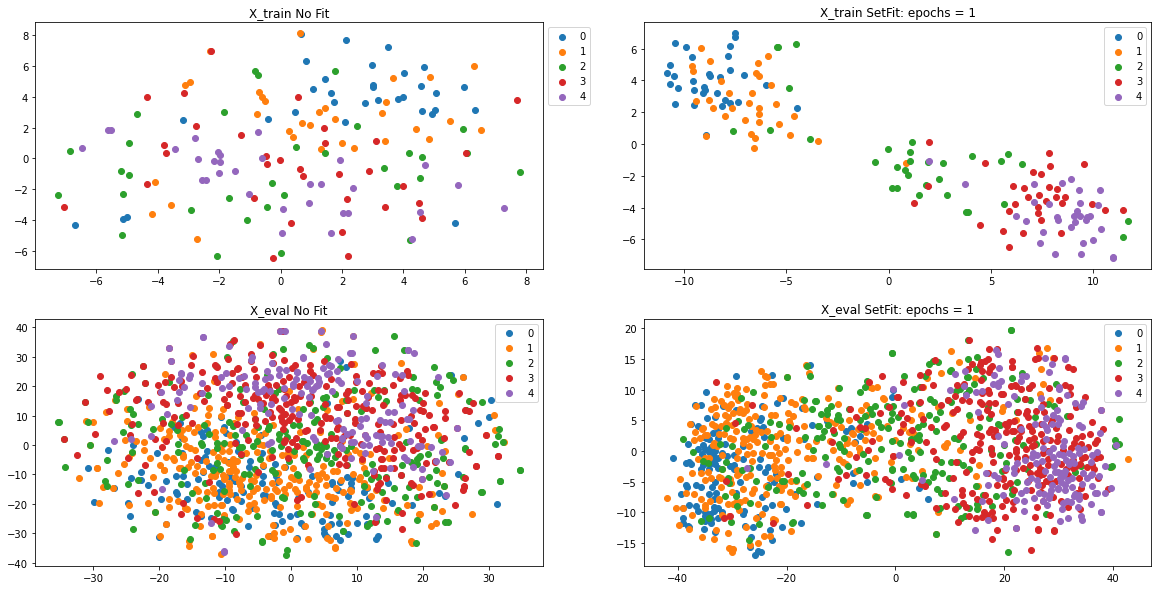

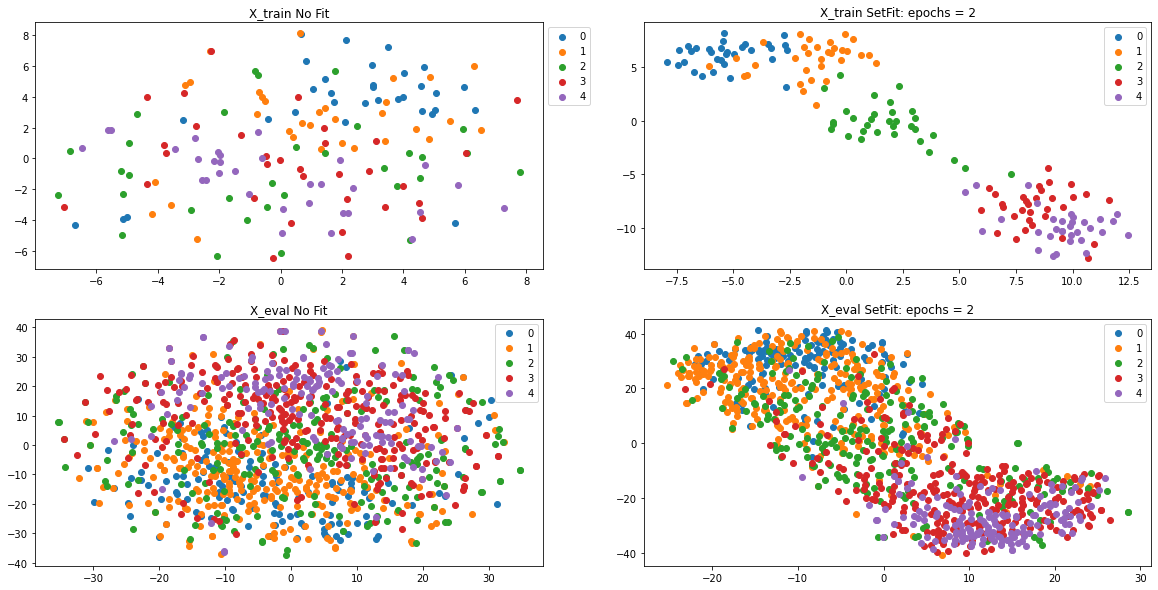

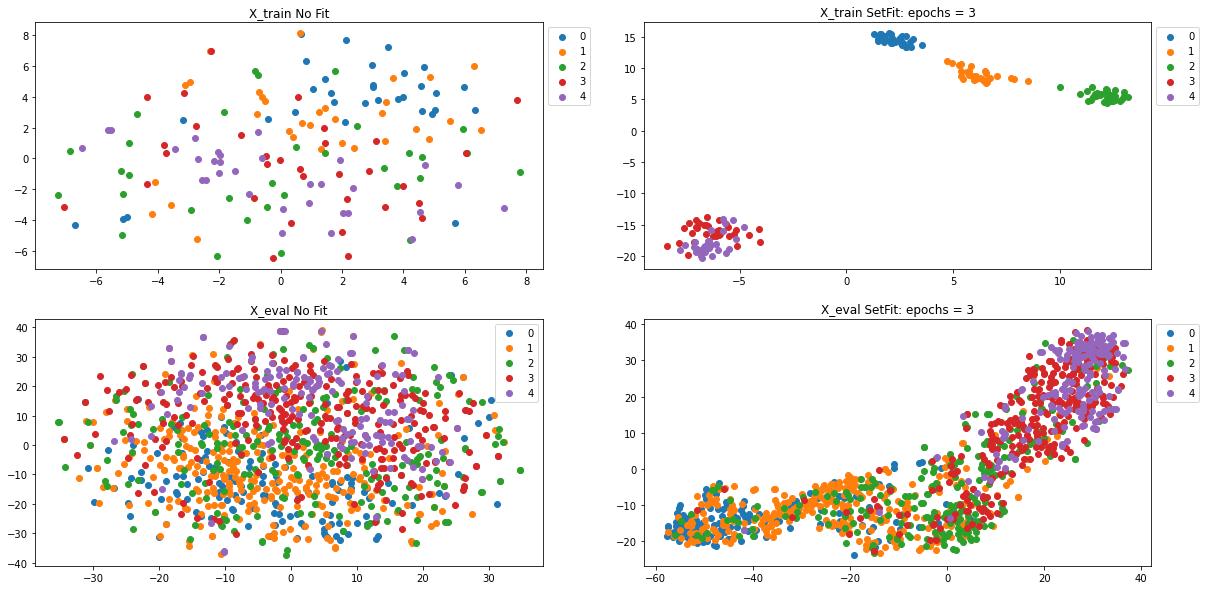

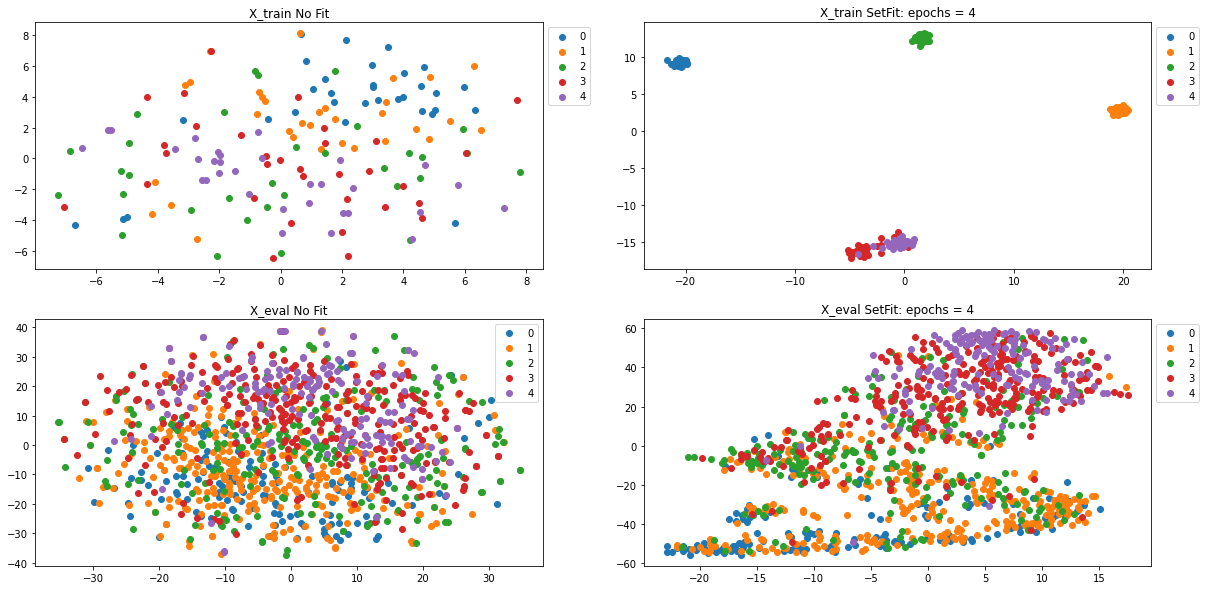

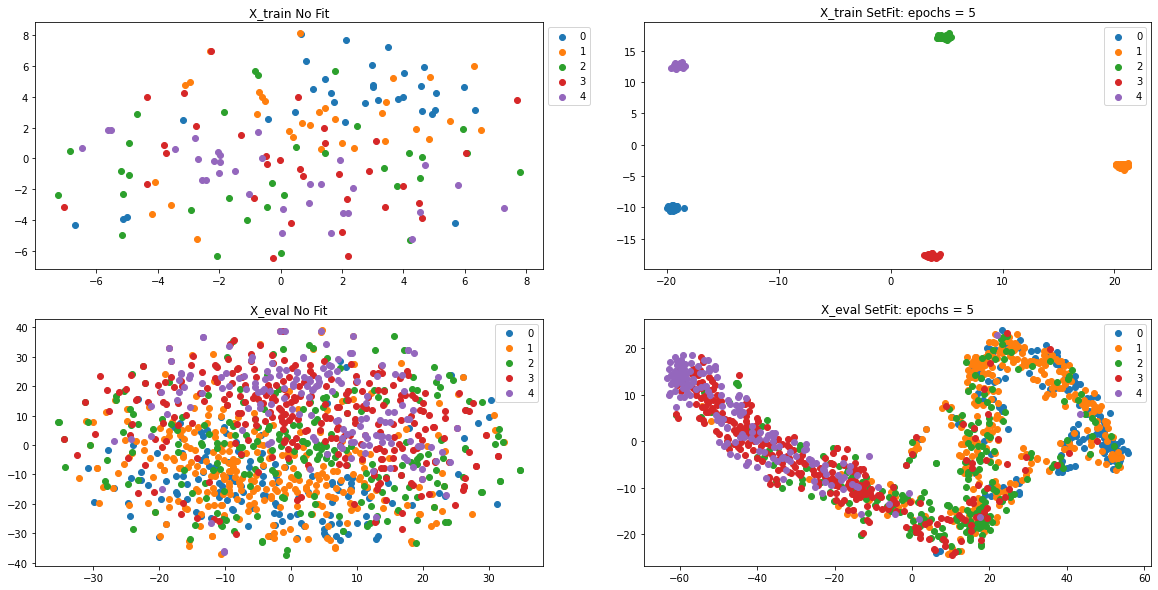

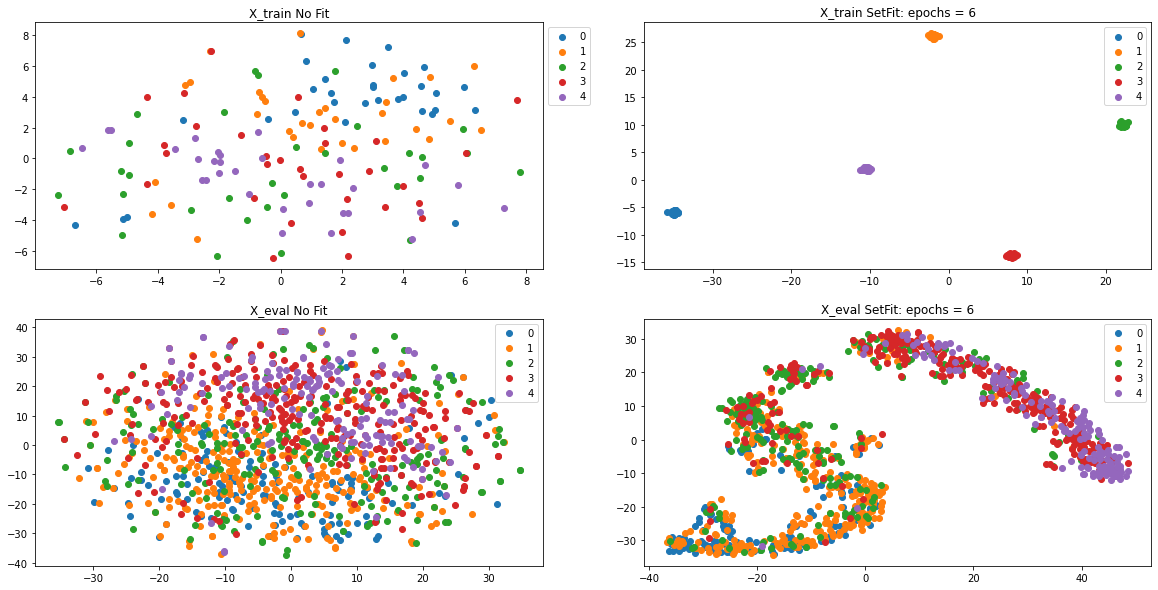

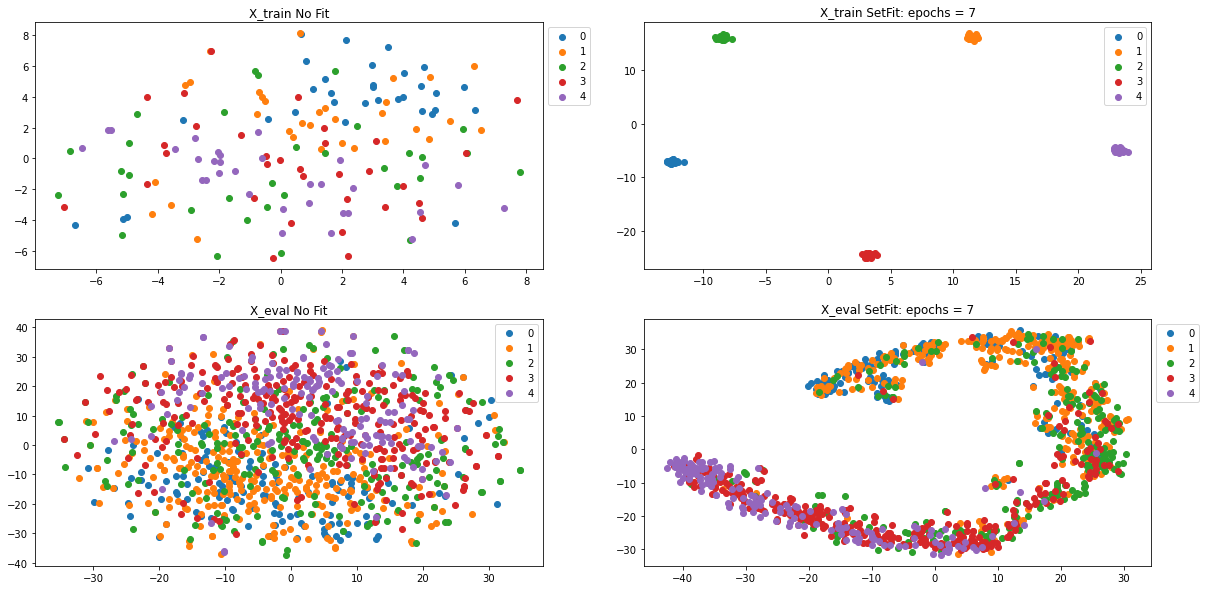

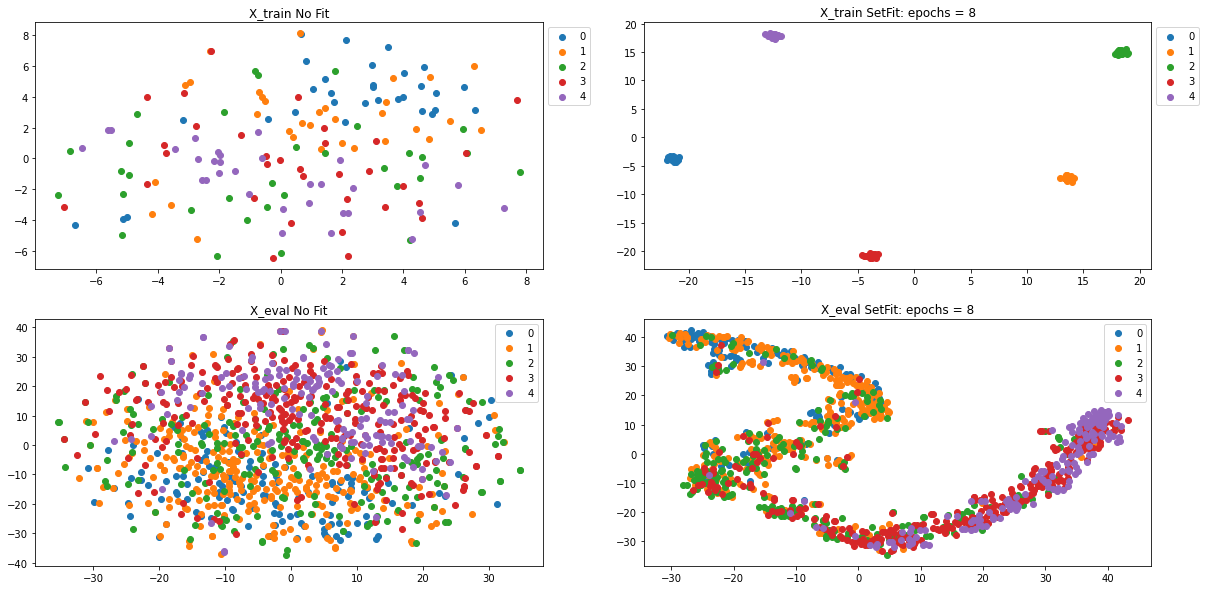

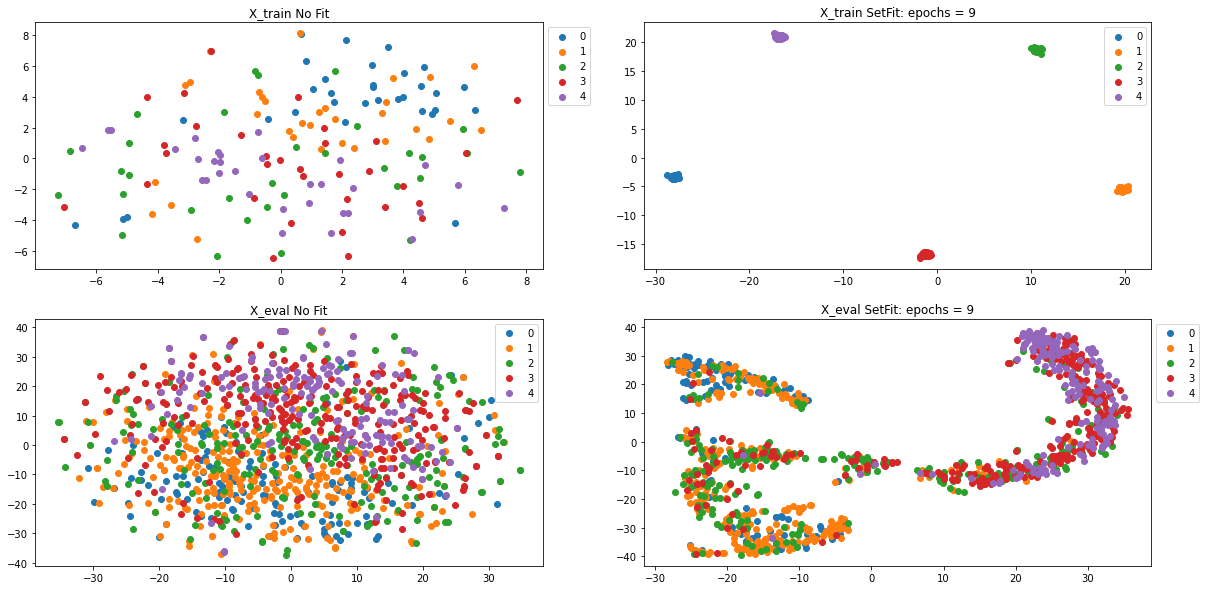

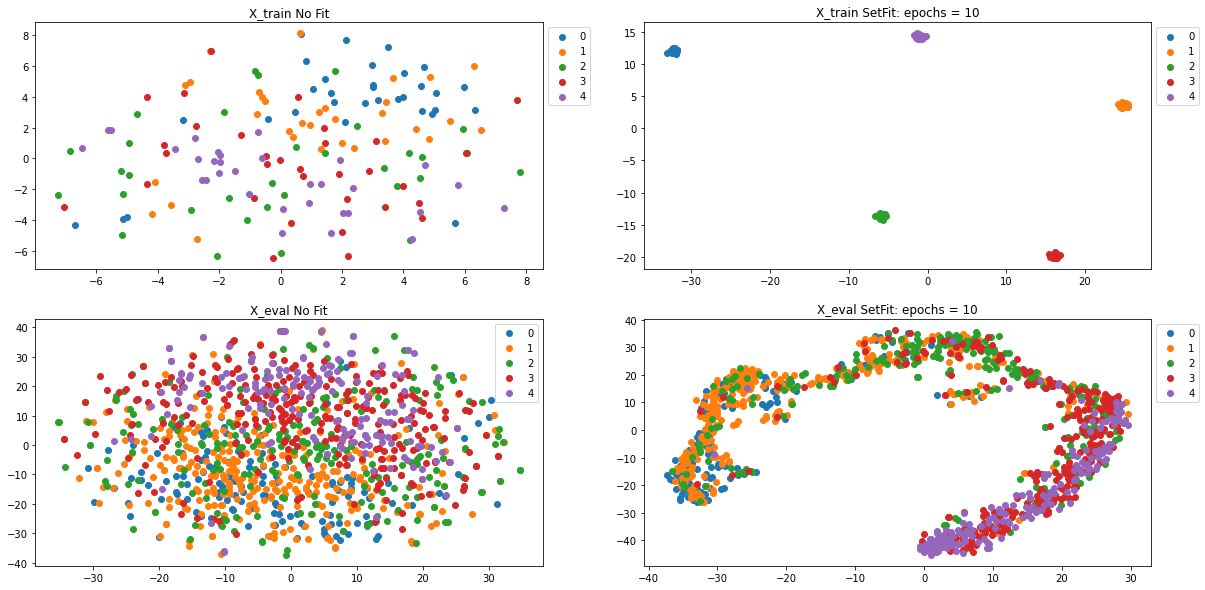

In [17]:
sst5_0_accs = []
for epoch in range(LOWER, UPPER):
    acc = SetFit(train_df, eval_df, epoch, neg_lab=0.0)
    sst5_0_accs.append(acc)

# SST-5 negative == -1

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 1
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4841053587647593


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 2
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.47774750227066304


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 3
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.47774750227066304


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 4
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4477747502270663


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 5
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.46503178928247046


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 6
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4586739327883742


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 7
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.45685740236148953


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 8
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.45776566757493187


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 9
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.4550408719346049


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

train epochs: 10
Acc. No Fit 0.4014532243415077
Acc. SetFit 0.45322434150772023


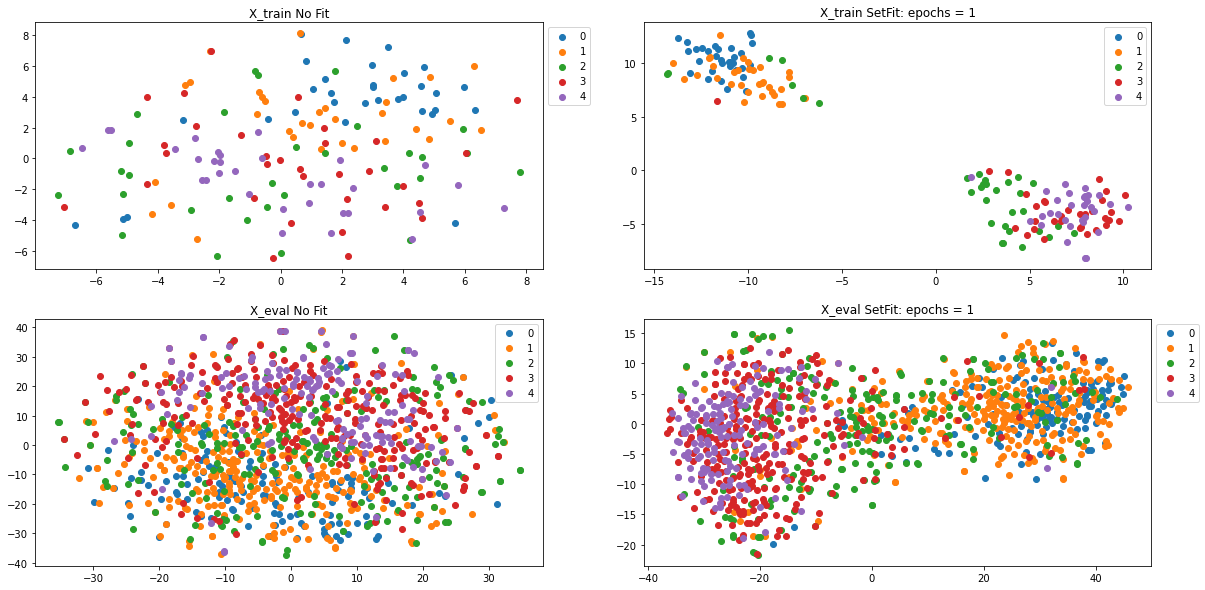

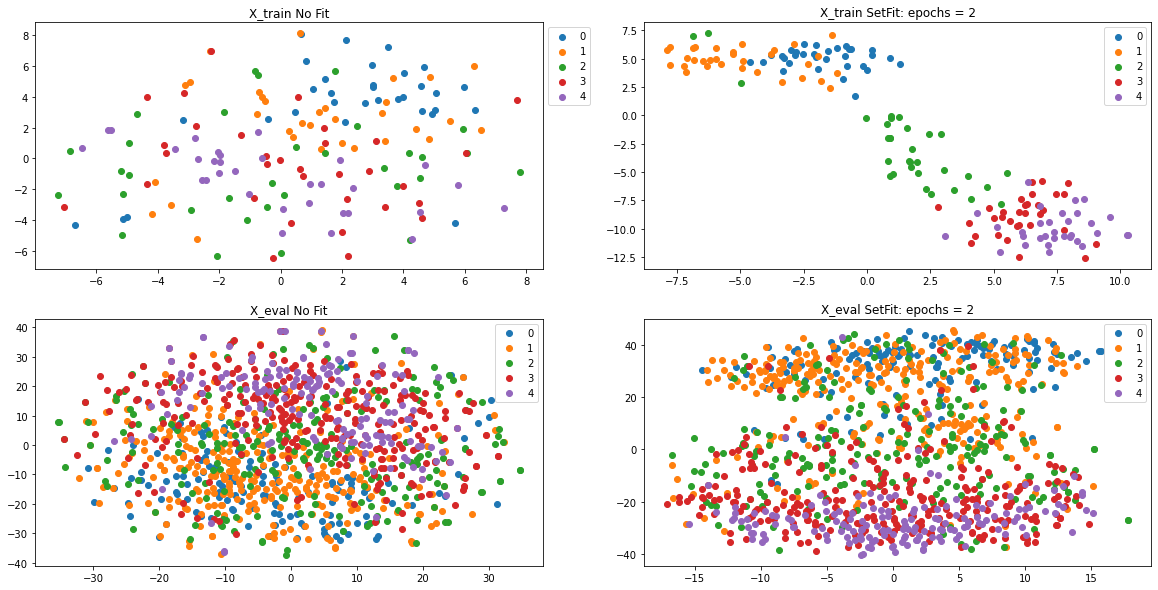

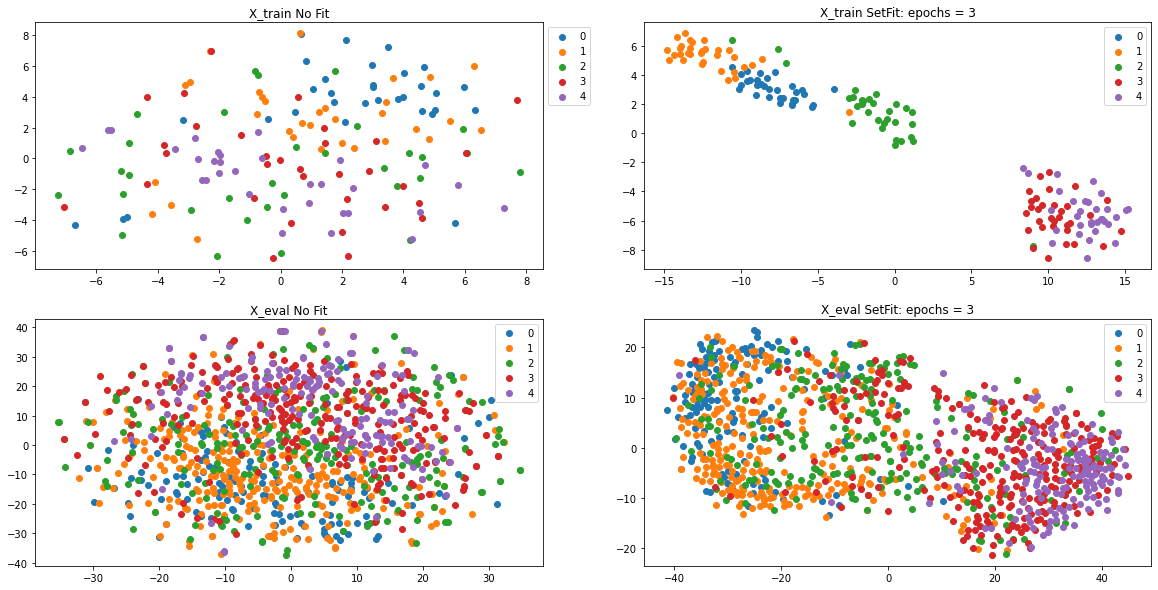

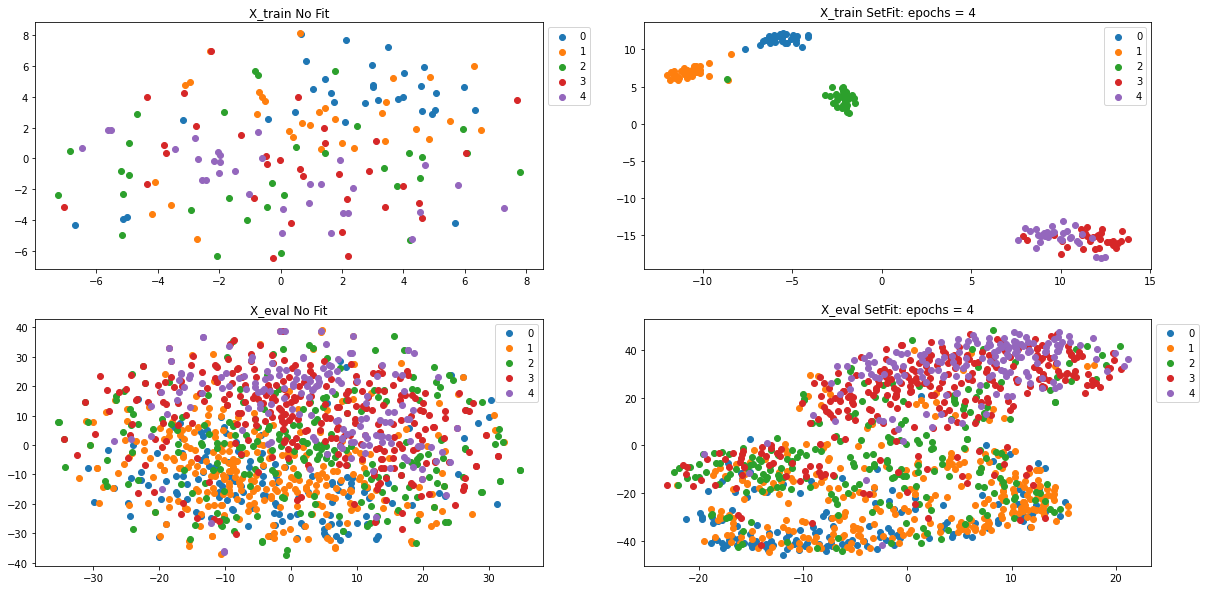

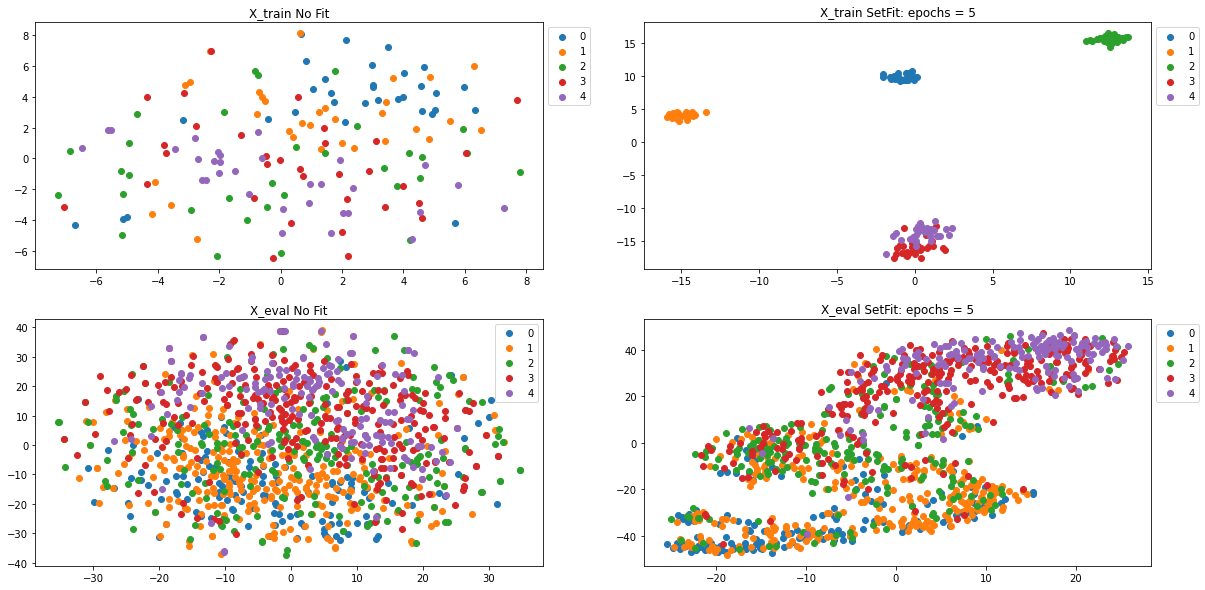

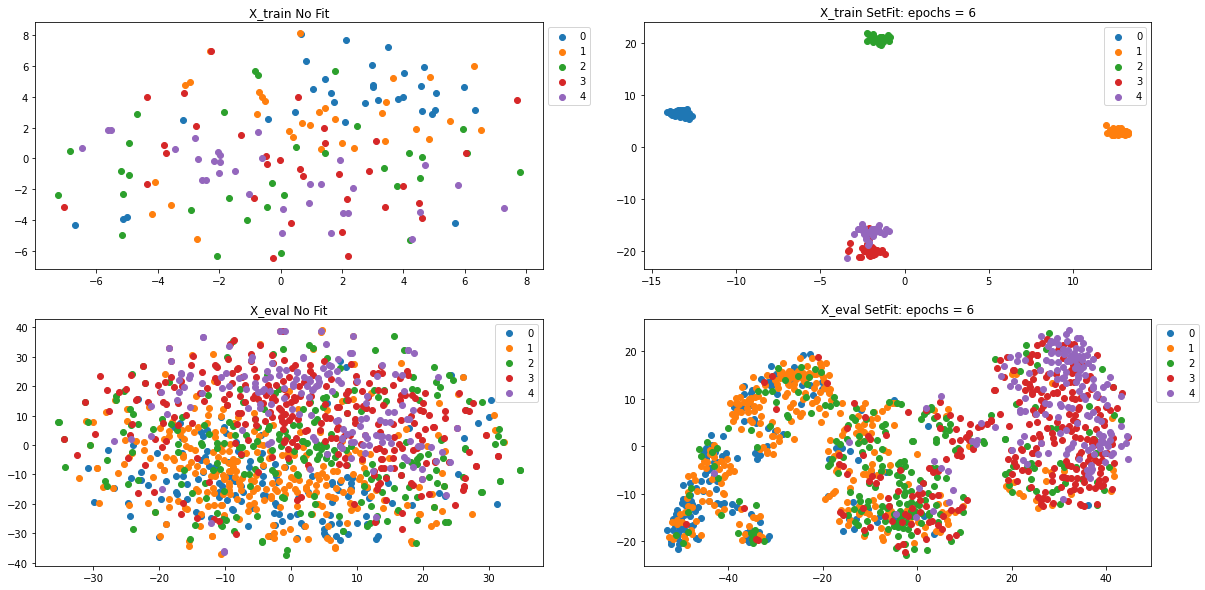

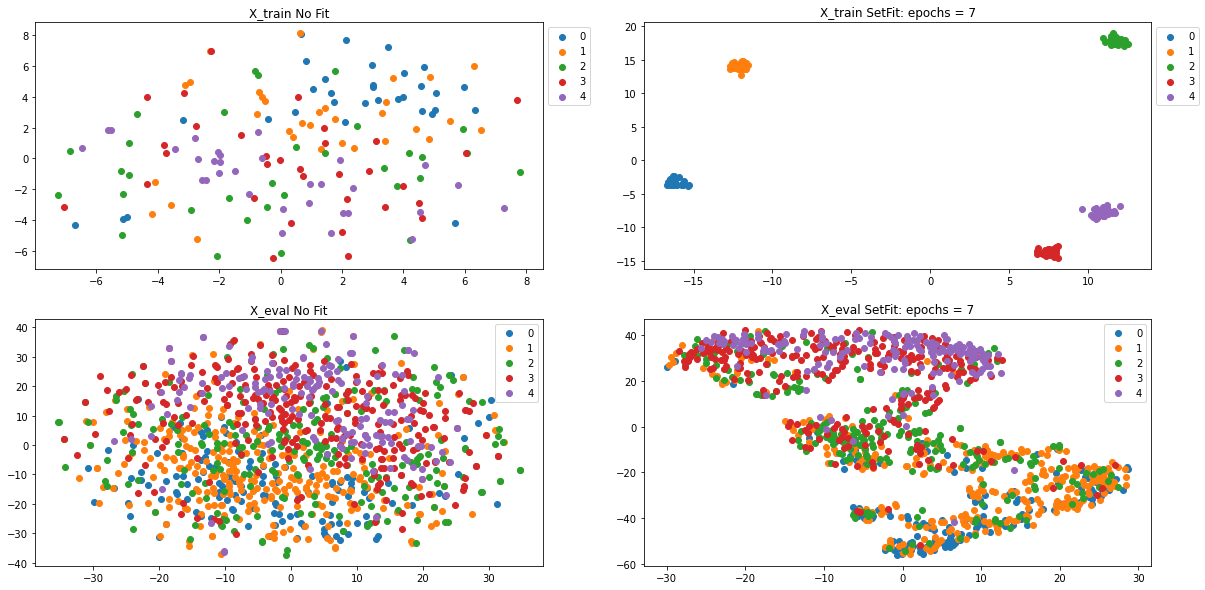

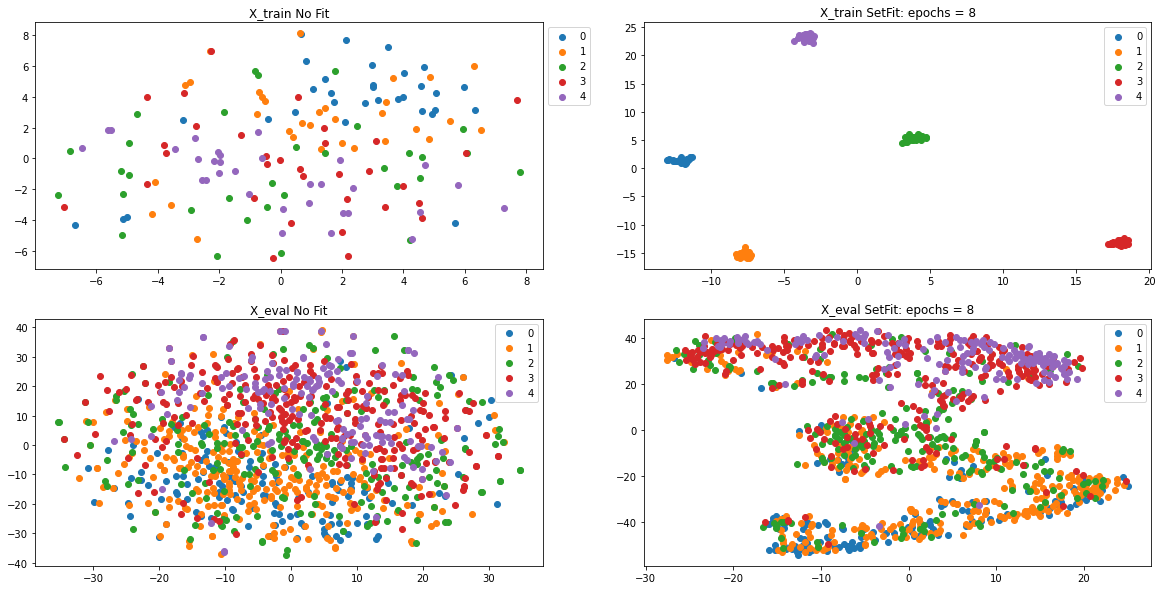

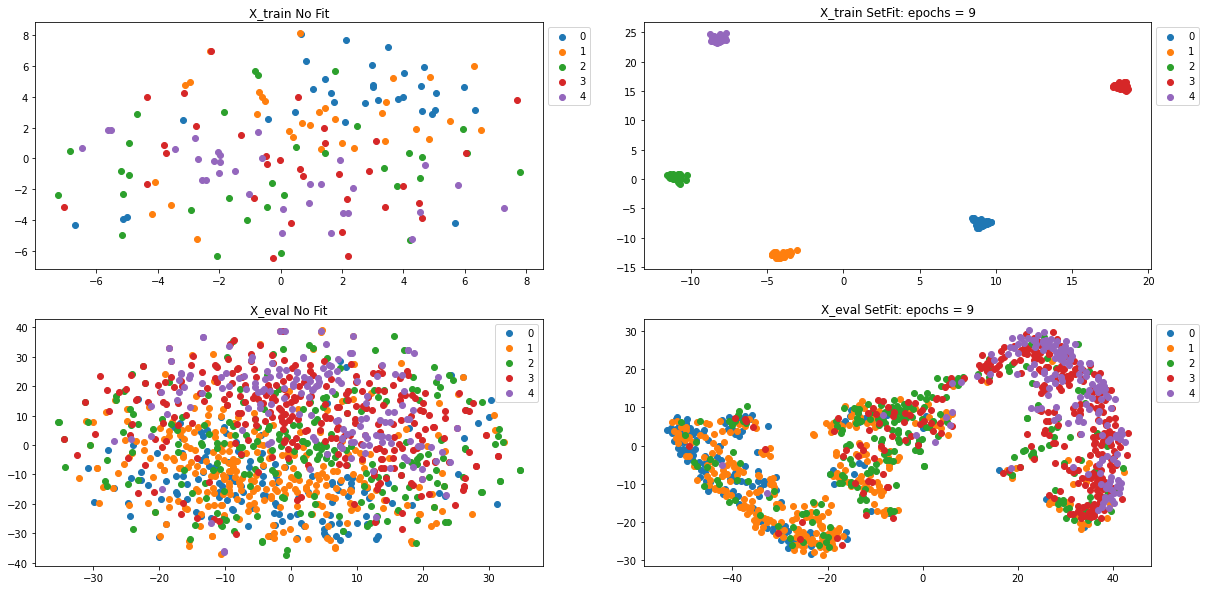

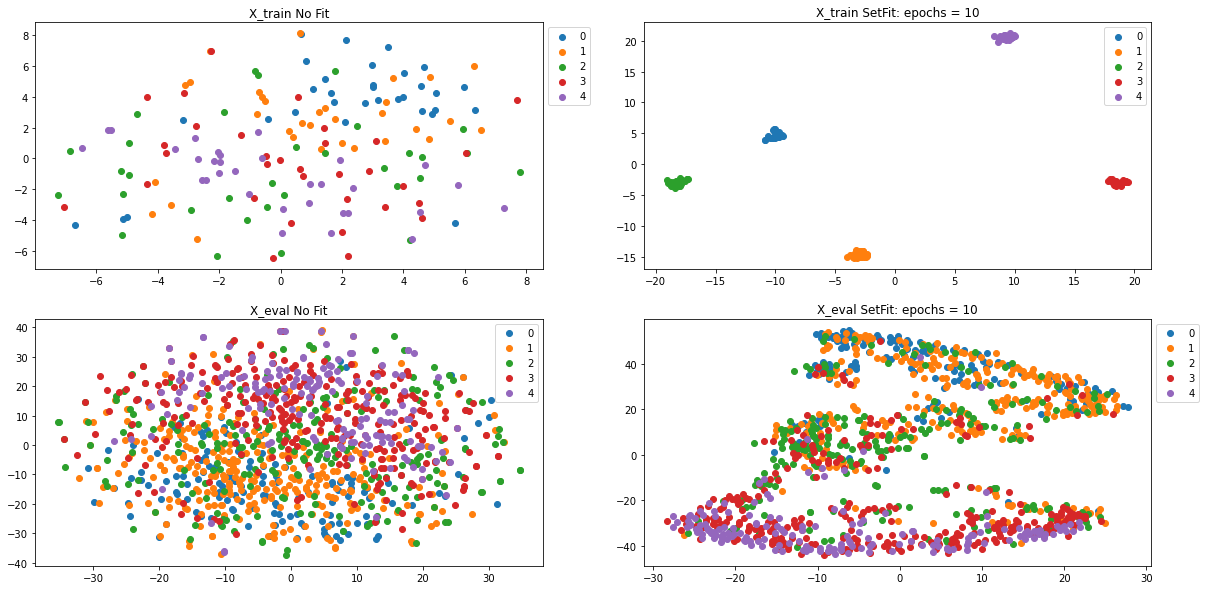

In [18]:
sst5_neg1_accs = []
for epoch in range(LOWER, UPPER):
    acc = SetFit(train_df, eval_df, epoch, neg_lab=-1.0)
    sst5_neg1_accs.append(acc)

In [19]:
print('Mean accuracy for SST2 with negative label = 0: {} \n'.format(np.mean(sst2_0_accs)))
print('Mean accuracy for SST2 with negative label = -1: {} \n'.format(np.mean(sst2_neg1_accs)))
print('Mean accuracy for SST5 with negative label = 0: {} \n'.format(np.mean(sst5_0_accs)))
print('Mean accuracy for SST5 with negative label = -1: {} \n'.format(np.mean(sst5_neg1_accs)))

Mean accuracy for SST2 with negative label = 0: 0.9047775947281714 

Mean accuracy for SST2 with negative label = -1: 0.8806699615595827 

Mean accuracy for SST5 with negative label = 0: 0.48546775658492286 

Mean accuracy for SST5 with negative label = -1: 0.4633969118982743 

